<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Method-2" data-toc-modified-id="Method-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Method 2</a></span></li><li><span><a href="#Method-3" data-toc-modified-id="Method-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method 3</a></span><ul class="toc-item"><li><span><a href="#MA-of-daily-tests" data-toc-modified-id="MA-of-daily-tests-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>MA of daily tests</a></span></li><li><span><a href="#Daily-case-positivity" data-toc-modified-id="Daily-case-positivity-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Daily case positivity</a></span></li><li><span><a href="#Percent-case-growth" data-toc-modified-id="Percent-case-growth-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Percent case growth</a></span></li></ul></li><li><span><a href="#Save-output-CSV" data-toc-modified-id="Save-output-CSV-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save output CSV</a></span></li></ul></div>

### Preprocessing

We first get the latest data by running the `extract_history.py` script

In [1]:
!python3 extract_history.py

INFO - Reading YAML
INFO - Fetching JSON from URL
INFO - Parsed JSON
INFO - Reading states and districts
INFO - Extracting data for State: MH
INFO - Appending State data
INFO - Writing data to output file
INFO - Output file created: /Users/saurabhjogalekar/swb/swb-ief/etl-pipeline/data_pipeline/output/city_stats.csv
INFO - Index(['Mumbai.total.confirmed', 'Mumbai.total.deceased',
       'Mumbai.total.recovered', 'Mumbai.delta.confirmed',
       'Mumbai.delta.deceased', 'Mumbai.delta.recovered',
       'Mumbai.delta.tested', 'Mumbai.total.tested', 'Mumbai.delta.other',
       'Mumbai.total.other'],
      dtype='object')


Read the output as a dataframe

In [2]:
import pandas as pd

In [21]:
df = pd.read_csv("output/city_stats.csv")

In [22]:
df.index = df["Unnamed: 0"]
df.index = pd.to_datetime(df.index)
df.drop("Unnamed: 0", axis=1, inplace=True)

In [23]:
df.tail()

,Mumbai.total.confirmed,Mumbai.total.deceased,Mumbai.total.recovered,Mumbai.delta.confirmed,Mumbai.delta.deceased,Mumbai.delta.recovered,Mumbai.delta.tested,Mumbai.total.tested,Mumbai.delta.other,Mumbai.total.other
Unnamed: 0,,,,,,,,,,
2020-08-26,139537.0,7505.0,112743.0,1854.0,28.0,781.0,19076.0,734619.0,4.0,310.0
2020-08-27,140888.0,7535.0,113577.0,1351.0,30.0,834.0,9266.0,743885.0,3.0,313.0
2020-08-28,142108.0,7565.0,114818.0,1220.0,30.0,1241.0,NaN,743885.0,5.0,318.0
2020-08-29,143389.0,7596.0,115500.0,1281.0,31.0,682.0,NaN,743885.0,4.0,322.0
2020-08-30,143389.0,7596.0,115500.0,NaN,NaN,NaN,NaN,743885.0,NaN,322.0


### Method 2

Find Levitt metrics for Mumbai

In [24]:
df["Mumbai.total.deceased.shift"] = df["Mumbai.total.deceased"].shift(1)

In [25]:
df.tail()

,Mumbai.total.confirmed,Mumbai.total.deceased,Mumbai.total.recovered,Mumbai.delta.confirmed,Mumbai.delta.deceased,Mumbai.delta.recovered,Mumbai.delta.tested,Mumbai.total.tested,Mumbai.delta.other,Mumbai.total.other,Mumbai.total.deceased.shift
Unnamed: 0,,,,,,,,,,,
2020-08-26,139537.0,7505.0,112743.0,1854.0,28.0,781.0,19076.0,734619.0,4.0,310.0,7477.0
2020-08-27,140888.0,7535.0,113577.0,1351.0,30.0,834.0,9266.0,743885.0,3.0,313.0,7505.0
2020-08-28,142108.0,7565.0,114818.0,1220.0,30.0,1241.0,NaN,743885.0,5.0,318.0,7535.0
2020-08-29,143389.0,7596.0,115500.0,1281.0,31.0,682.0,NaN,743885.0,4.0,322.0,7565.0
2020-08-30,143389.0,7596.0,115500.0,NaN,NaN,NaN,NaN,743885.0,NaN,322.0,7596.0


In [26]:
df["Mumbai.Levitt.Metric"] = df["Mumbai.total.deceased"]/df["Mumbai.total.deceased.shift"]

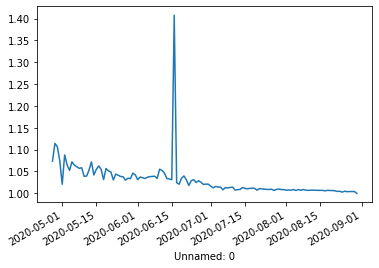

In [30]:
df["Mumbai.Levitt.Metric"].plot()

In [27]:
df.tail()

,Mumbai.total.confirmed,Mumbai.total.deceased,Mumbai.total.recovered,Mumbai.delta.confirmed,Mumbai.delta.deceased,Mumbai.delta.recovered,Mumbai.delta.tested,Mumbai.total.tested,Mumbai.delta.other,Mumbai.total.other,Mumbai.total.deceased.shift,Mumbai.Levitt.Metric
Unnamed: 0,,,,,,,,,,,,
2020-08-26,139537.0,7505.0,112743.0,1854.0,28.0,781.0,19076.0,734619.0,4.0,310.0,7477.0,1.003745
2020-08-27,140888.0,7535.0,113577.0,1351.0,30.0,834.0,9266.0,743885.0,3.0,313.0,7505.0,1.003997
2020-08-28,142108.0,7565.0,114818.0,1220.0,30.0,1241.0,NaN,743885.0,5.0,318.0,7535.0,1.003981
2020-08-29,143389.0,7596.0,115500.0,1281.0,31.0,682.0,NaN,743885.0,4.0,322.0,7565.0,1.004098
2020-08-30,143389.0,7596.0,115500.0,NaN,NaN,NaN,NaN,743885.0,NaN,322.0,7596.0,1.000000


### Method 3

21-day moving averages

#### MA of daily tests

In [31]:
df["Mumbai.MA.daily.tests"] = df["Mumbai.delta.tested"].rolling(window=21).mean()

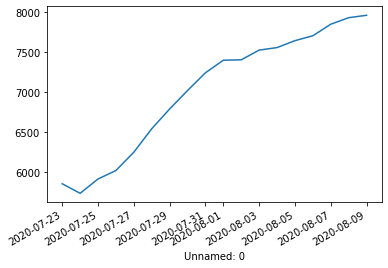

In [32]:
df["Mumbai.MA.daily.tests"].plot()

#### Daily case positivity

We find daily positivity by dividing daily confirmed cases by the number of tests

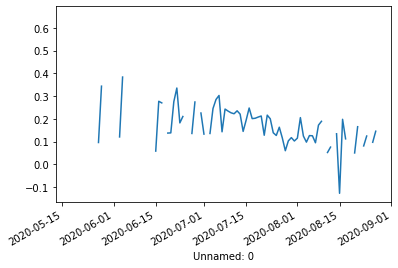

In [33]:
df["Mumbai.MA.daily.positivity"] = df["Mumbai.delta.confirmed"]/df["Mumbai.delta.tested"]
df["Mumbai.MA.daily.positivity"].plot()

#### Percent case growth



In [39]:
df["Mumbai.percent.case.growth"] = df["Mumbai.delta.confirmed"].pct_change()

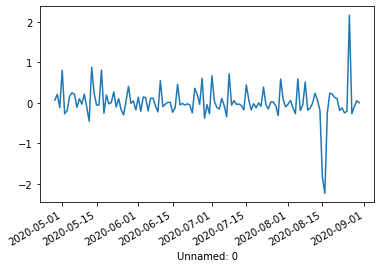

In [40]:
df["Mumbai.percent.case.growth"].plot()

### Save output CSV

In [45]:
df.to_csv("output/metrics.csv")